# Amazon Fine Food Reviews Analysis

## [1]. Reading Data

### [1.1] Loading the data

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

## [2] Exploratory Data Analysis

### [2.1] Data Cleaning: Deduplication

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

## [3] Preprocessing

### [3.1]. Preprocessing Review Tex

In [0]:
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [0]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:57<00:00, 1527.44it/s]


## [4] Featurization

### [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


### [4.2] Bi-Grams and n-Grams

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


### [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


# [5] Truncated SVD

## [5.1] Taking top features from TFIDF

In [0]:
# Standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean = False)
std_data = std.fit_transform(final_tf_idf)
std_data

<87773x51709 sparse matrix of type '<class 'numpy.float64'>'
	with 4107655 stored elements in Compressed Sparse Row format>

In [0]:
# List of vocabulary
list(tf_idf_vect.vocabulary_.keys())[0:10]

['dogs',
 'loves',
 'chicken',
 'product',
 'china',
 'wont',
 'buying',
 'anymore',
 'hard',
 'find']

In [0]:
# List of vocabulary values 
list(tf_idf_vect.vocabulary_.values())[0:10]

[12123, 26483, 7384, 35753, 7502, 50846, 6032, 1845, 20976, 15630]

In [0]:
# Get feature names from tfidf
features = tf_idf_vect.get_feature_names()
# feature weights based on idf score
coef = tf_idf_vect.idf_
# Store features with their idf score in a dataframe
coeff_df = pd.DataFrame({'Features' : features, 'Idf_score' : coef})
coeff_df = coeff_df.sort_values("Idf_score", ascending = True)[:2000]
print("shape of selected features :", coeff_df.shape)
print("Top 5 features :\n\n",coeff_df[0:10])

shape of selected features : (2000, 2)
Top 5 features :

       Features  Idf_score
30359      not   1.605378
24554     like   2.198111
19289     good   2.312714
20089    great   2.412216
31964      one   2.500359
44466    taste   2.516372
51056    would   2.591810
35753  product   2.653863
26110     love   2.681394
16145   flavor   2.697065


## [5.2] Calulation of Co-occurrence matrix 

In [0]:
# co-occurence matrix
co_occurence_matrix = np.zeros((len(coeff_df), len(coeff_df)))
print(co_occurence_matrix.shape)
df = pd.DataFrame(co_occurence_matrix, index = coeff_df["Features"], columns = coeff_df["Features"])
df.shape

(2000, 2000)


(2000, 2000)

In [0]:
# Calculate Co-Occurrence Matrix 
# with windows size 4 in forward and backward pass
%time
window_size = 4
for sent in preprocessed_reviews:
    word = sent.split(" ")
    for i, d in enumerate(word):
        for j in range(max(i - window_size, 0), min(i + window_size, len(word))):
            if (word[i] != word[j]):
                    try:
                        df.loc[word[i], word[j]] += 1
                        df.loc[word[j], word[i]] += 1
                    except:
                        pass

Wall time: 0 ns


In [0]:
df.head()

Features,not,like,good,great,one,taste,would,product,love,flavor,...,occasional,whole family,pressure,amazon great,blueberry,work well,unpleasant,odor,equal,punch
Features,,,,,,,,,,,,,,,,,,,,,
not,0.0,22131.0,13164.0,6663.0,9091.0,15185.0,12803.0,8286.0,4599.0,9845.0,...,87.0,0.0,110.0,0.0,112.0,0.0,224.0,219.0,129.0,112.0
like,22131.0,0.0,4346.0,2482.0,3596.0,9801.0,4900.0,2648.0,2019.0,4387.0,...,29.0,0.0,32.0,0.0,89.0,0.0,57.0,66.0,32.0,92.0
good,13164.0,4346.0,0.0,2498.0,2701.0,6394.0,3038.0,3729.0,1660.0,4085.0,...,37.0,0.0,36.0,0.0,52.0,0.0,18.0,28.0,20.0,32.0
great,6663.0,2482.0,2498.0,0.0,1668.0,5480.0,1935.0,5516.0,2293.0,3932.0,...,22.0,0.0,20.0,0.0,34.0,0.0,7.0,23.0,9.0,30.0
one,9091.0,3596.0,2701.0,1668.0,0.0,1940.0,2569.0,1315.0,1503.0,1820.0,...,31.0,0.0,13.0,0.0,43.0,0.0,18.0,20.0,44.0,21.0


## [5.3] Finding optimal value for number of components (n) to be retained

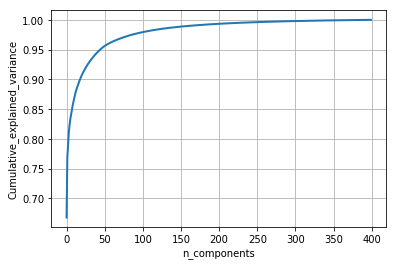

In [0]:
# TrucatedSVD
from sklearn.decomposition import TruncatedSVD
ts = TruncatedSVD(n_components = 400)
ts_data = ts.fit_transform(df)

percentage_var_explained = ts.explained_variance_ / np.sum(ts.explained_variance_)

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth = 2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

## [5.4] Applying k-means clustering

In [0]:
# Elbow method to find K 
def find_optimal_k(data):
    loss = []
    k = list(range(2, 15, 2))
    for noc in k:
        model = KMeans(n_clusters = noc)
        model.fit(data)
        loss.append(model.inertia_)
    plt.plot(k, loss, "-o")
    plt.title("Elbow method to choose k")
    plt.xlabel("K")
    plt.ylabel("Loss")
    plt.show()

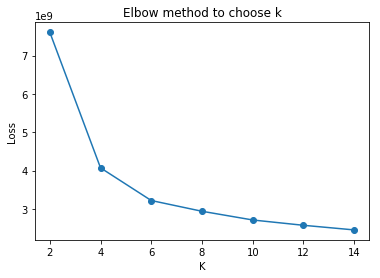

In [0]:
# Find best k using elbow method
find_optimal_k(ts_data)

In [0]:
# After applying truncated svd store data into dataframe
df = pd.DataFrame(ts_data)

In [0]:
# Data shape
df.shape

(2000, 400)

In [0]:
# K-means clustering
clf = KMeans(n_clusters = 10)
clf.fit(ts_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [0]:
# Assign each data-points with its correspondincg label
df["Cluster_labels"] = clf.labels_
df["Words"] = coeff_df["Features"].values     
df.head()

,0,1,2,3,4,5,6,7,8,9,...,392,393,394,395,396,397,398,399,Cluster_labels,Words
0,47215.625631,28714.108289,-485.427388,816.159495,1631.876515,-988.146745,-217.728711,1164.184099,-299.556860,-700.501160,...,2.479829,0.919265,-0.103852,-0.103086,-2.137211,-0.026973,-1.548226,1.205910,1,not
1,27970.184723,-10604.126647,-3765.317659,8187.460166,2016.784608,-788.574999,-1755.191258,560.763540,-2766.710744,-820.757188,...,2.391075,0.627325,-1.156193,2.517411,-2.362673,-0.411215,3.562161,3.975728,4,like
2,20709.581567,-4005.340506,-1243.307962,4986.340604,-325.188110,-1363.594093,1972.632567,-807.954440,1372.562464,532.614656,...,1.791877,1.135360,-0.167370,-1.629592,5.367160,4.140593,2.568772,-0.663203,8,good
3,15081.757186,-50.092773,120.002652,5135.196557,-2269.012568,-1196.628244,2377.231440,-2327.331986,1475.378670,1945.881829,...,-6.992175,-2.756095,-2.866200,-0.668453,-3.099621,-3.862642,2.214852,4.933953,8,great
4,15129.380055,-2327.386702,1428.802207,-650.210016,-316.670895,2599.730332,450.631385,830.847847,-408.198974,-177.629466,...,5.740939,5.450383,4.652200,3.253933,3.692630,-4.069471,-0.598506,-5.850733,7,one


In [0]:
reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])
    elif kmeans.labels_[i] == 5:
        cluster6.append(reviews[i])
    elif kmeans.labels_[i] == 6:
        cluster7.append(reviews[i])
    elif kmeans.labels_[i] == 7:
        cluster8.append(reviews[i])
    else :
        cluster9.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))
print("\nNo. of reviews in Cluster-9 : ",len(cluster9))

No. of reviews in Cluster-1 :  1493

No. of reviews in Cluster-2 :  7

No. of reviews in Cluster-3 :  31

No. of reviews in Cluster-4 :  1

No. of reviews in Cluster-5 :  126

No. of reviews in Cluster-6 :  338

No. of reviews in Cluster-7 :  1

No. of reviews in Cluster-8 :  1

No. of reviews in Cluster-9 :  2


### [5.5] Wordclouds of clusters obtained in the above section

In [0]:
#Reading reviews manually
cluster1[0]

'disappointed regular nylabones pound dogs chewed sharp dangerous chunks within matter minutes wary nylabone products durable ones turned great buy durable dogs like bone shaped durable nylabones love dinosaurs never seem get tired chomping wear slowly tiny pieces appear harmless month three dogs working two dinosaurs toys missing heads plenty chew irregular shape makes easy hold onto fun go different angles house never without things'

[nltk_data] Downloading package punkt to C:\Users\BALARAMI
[nltk_data]     REDDY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
cluster1 Word-Cloud


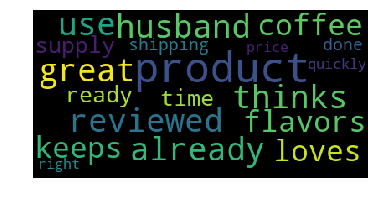

In [0]:
import nltk
nltk.download('punkt')
  

for val in cluster1:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster1
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster1 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster1_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster2[0]

'wish would read reviews making purchase basically cardsotck box sticky outside pink ish things look like entrances trap pictures no inside trap flies stuck outside basically fly paper horribly horribly horribly overpriced favor get fly paper fly strips yuck factor much cheaper'

cluster2 Word-Cloud


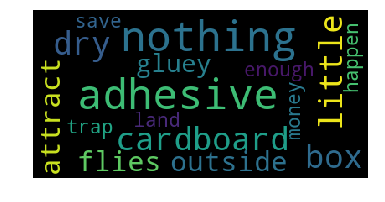

In [0]:
for val in cluster2:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster2
    for words in tokens:
        cluster2_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster2 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster2_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster3[0]

'placed around house several days setup fly attracting trap vicinity literally watched flies avoid trap days excited see one lil bugger land surface disappointed approached examine flew away paper tacky pressure human finger applied small flies hardly trap'

cluster3 Word-Cloud


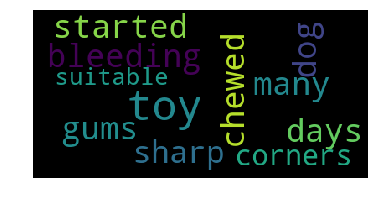

In [0]:
for val in cluster3:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster3
    for words in tokens:
        cluster3_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster3 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster3_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster4[0]

'dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports'

cluster4 Word-Cloud


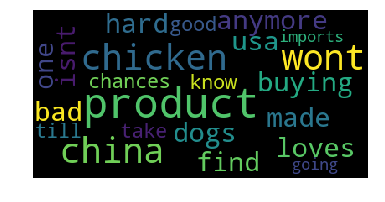

In [0]:
for val in cluster4:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster4
    for words in tokens:
        cluster4_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster4 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster4_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster5[0]

'time spent waiting order fly traps arrive went bought regular fly ribbon bad fly problem not sure kind flies slightly bigger fruit flies least week one fly traps caught zero flies fly trap caught probably flies regular fly ribbon one point even saw fly fly trap thought caught gone even pictures prove'

cluster5 Word-Cloud


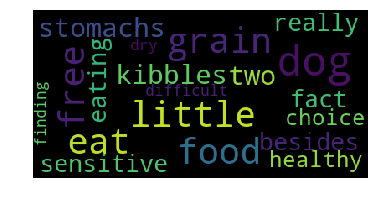

In [0]:
for val in cluster5:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster5
    for words in tokens:
        cluster5_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster5 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster5_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster6[0]

'two terrier mixes lbs lbs love chew paws favorites past five years nylabone dental dinosaurs go sets per year no problems exception occasion bit gum bleeding slight someone gets bit carried away well confiscate toys trying sleep since chewing enjoyment bit noisy nighttime months use take worn toys away replace regularly check make sure no sharp edges larger parts look could break ingested dog loves chewing say give try first supervision dogs like mine toys offer many hours entertainment cleaner teeth boot'

cluster6 Word-Cloud


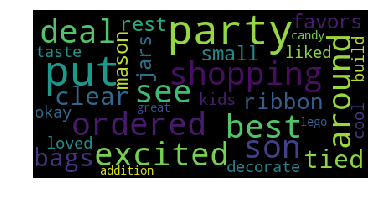

In [0]:
for val in cluster6:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster6
    for words in tokens:
        cluster6_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster6 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster6_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster7[0]

'happy item many flies disturbing kitchen put product near window works fantastically'

cluster7 Word-Cloud


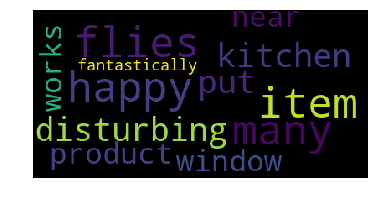

In [0]:
for val in cluster7:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster7
    for words in tokens:
        cluster7_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster7 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster7_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster8[0]

'dogs love saw pet store tag attached regarding made china satisfied safe'

cluster8 Word-Cloud


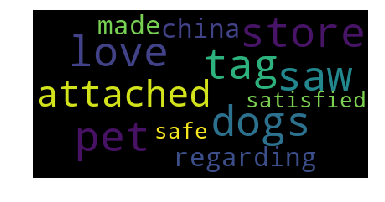

In [0]:
for val in cluster8:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster8
    for words in tokens:
        cluster8_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster8 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster8_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster9[0]

'infestation fruitflies literally everywhere flying around kitchen bought product hoping least get rid weeks fly stuck going around notepad squishing buggers success rate day clearly product useless even dabbed red wine banana top column week really attracted red wine glass still nothing get stuck actually saw second fly land watched flapped wings frantically within secs unstuck product total waste money'

cluster9 Word-Cloud


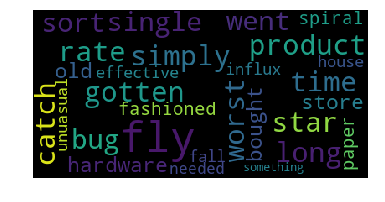

In [0]:
for val in cluster9:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    tokens = cluster9
    for words in tokens:
        cluster9_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster9 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster9_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
# Calculate cosine similarity
from sklearn.metrics import pairwise_distances
def cosine_similarity(word_index, total_results):
    # calculate pairwise distances from given word
    # The smaller the distance, the more similar the word
    dist = pairwise_distances(ts_data, ts_data[word_index:word_index + 1,:])
    # Store index of the distances
    indices = np.argsort(dist.flatten())[0:total_results]
    # Sort distances 
    pdist = np.sort(dist.flatten())[0:total_results]
    # put indices at particular index of dataframe
    df_indices = list(df.index[indices])
    print("Most_Similar Words \t Distances")
    # Loop through indices and find match
    for i in range(len(indices)): 
        if indices[i] == df.index[indices[i]]:
            print(df.Words.loc[indices[i]], "\t\t\t", dist[indices[i]])

In [0]:
# given index of a word
# find how similar words are from this index word
cosine_similarity(119, 7)

Most_Similar Words 	 Distances
tasty 			 [0.00010572]
kind 			 [1444.80315447]
however 			 [1497.55146585]
although 			 [1499.9365148]
things 			 [1507.055186]
may 			 [1510.99135107]
probably 			 [1519.11947247]


In [0]:
# given index of a word
# find how similar words are from this index word
cosine_similarity(56, 7)

Most_Similar Words 	 Distances
still 			 [0.]
however 			 [1686.2278009]
lot 			 [1869.50328975]
say 			 [1906.01828543]
stuff 			 [1913.51065679]
way 			 [1976.85773448]
actually 			 [2009.43636588]
